# Récupère 5 offres d'emplois sur hellowork à partir d'un mot clé (ici : Data Analyst)

In [1]:
import csv
import os
import time
from datetime import datetime

LATENCY_CSV = 'latence_etapes.csv'
LATENCY_RUN_ID = datetime.now().strftime('%Y%m%d_%H%M%S')

class LatencyLogger:
    def __init__(self, csv_path, run_id):
        self.csv_path = csv_path
        self.run_id = run_id

    def start(self):
        return time.perf_counter()

    def stop(self, step, start_ts):
        elapsed = time.perf_counter() - start_ts
        self._append_row(step, elapsed)
        return elapsed

    def _append_row(self, step, seconds):
        header = ['run_id', 'step', 'seconds']
        file_exists = os.path.exists(self.csv_path)
        with open(self.csv_path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=header)
            if (not file_exists) or f.tell() == 0:
                writer.writeheader()
            writer.writerow({'run_id': self.run_id, 'step': step, 'seconds': round(seconds, 4)})

latency_logger = LatencyLogger(LATENCY_CSV, LATENCY_RUN_ID)
print(f'Latency logger ready. run_id={LATENCY_RUN_ID}')


Latency logger ready. run_id=20251229_104219


In [2]:
_latency_start = latency_logger.start()
import time
import pandas as pd
import urllib.parse
import re  # Import nécessaire pour le nettoyage des espaces
from selenium import webdriver
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By

# --- 1. FONCTION DE NETTOYAGE (NOUVEAU) ---
def clean_text(text):
    """
    Nettoie le texte pour garantir qu'il tient sur une seule ligne.
    - Remplace les sauts de ligne (\n, \r) par des espaces.
    - Supprime les espaces multiples inutiles.
    """
    if not isinstance(text, str):
        return str(text) if text is not None else ""
    
    # Remplace les retours à la ligne par un espace simple
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # Remplace les suites d'espaces (ex: "  ") par un seul espace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# --- 2. FONCTION POUR SÉPARER LE TEXTE ---
def extract_mission_profil(full_text):
    """
    Essaie de couper le texte en deux parties : Missions et Profil.
    Renvoie les textes nettoyés (sans sauts de ligne).
    """
    if not full_text:
        return "", ""

    text_lower = full_text.lower()
    
    profil_keywords = ["profil", "ce que nous recherchons", "votre profil", "compétences", "pré-requis", "attendus"]
    
    split_index = -1
    for keyword in profil_keywords:
        idx = text_lower.find(keyword)
        if idx != -1:
            # On évite de couper si le mot clé est au tout début (ex: titre)
            if idx > len(full_text) * 0.1: 
                split_index = idx
                break
    
    if split_index != -1:
        missions = full_text[:split_index]
        profil = full_text[split_index:]
    else:
        missions = full_text
        profil = "Non identifié spécifiquement (voir colonne Missions)"
        
    # IMPORTANT : On nettoie le texte avant de le renvoyer
    return clean_text(missions), clean_text(profil)

# --- 3. FONCTION PRINCIPALE ---
def get_jobs_detailed_hellowork(keyword, num_jobs=10):
    print(f"🚀 Démarrage de la recherche approfondie pour : {keyword}...")
    
    encoded_keyword = urllib.parse.quote_plus(keyword)
    url = f"https://www.hellowork.com/fr-fr/emploi/recherche.html?k={encoded_keyword}"
    
    options = Options()
    options.add_argument("--start-maximized")
    # User agent pour éviter d'être bloqué trop vite
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")
    options.add_argument("--disable-blink-features=AutomationControlled")
    
    driver = webdriver.Edge(options=options)
    all_jobs_data = []
    
    try:
        # --- PHASE 1 : RÉCUPÉRATION DES LIENS ET DU LIEU ---
        print("1️⃣  PHASE 1 : Récupération des liens et des lieux...")
        driver.get(url)
        time.sleep(4)
        
        # Gestion des cookies
        try:
            buttons = driver.find_elements(By.TAG_NAME, "button")
            for btn in buttons:
                if "continuer sans" in btn.text.lower() or "refuser" in btn.text.lower():
                    btn.click()
                    break
            time.sleep(1)
        except: pass

        potential_jobs = driver.find_elements(By.CSS_SELECTOR, "ul > li")
        job_links = []
        
        for card in potential_jobs:
            if len(job_links) >= num_jobs:
                break
            try:
                if card.find_elements(By.TAG_NAME, "h3"):
                    link_elem = card.find_element(By.TAG_NAME, "a")
                    link = link_elem.get_attribute("href")
                    
                    # Titre
                    raw_title = card.find_element(By.TAG_NAME, "h3").text.split('\n')[0]
                    
                    # Extraction Entreprise et Lieu via le texte brut de la carte
                    txt_lines = card.text.split('\n')
                    
                    # L'entreprise est souvent en 2ème ligne
                    raw_company = txt_lines[1] if len(txt_lines) > 1 else "N/A"
                    if raw_company == raw_title and len(txt_lines) > 2: 
                         raw_company = txt_lines[2]

                    # Le lieu est souvent en 3ème ligne
                    raw_location = "N/A"
                    if len(txt_lines) > 2:
                        potential_loc = txt_lines[2]
                        if len(potential_loc) < 50: 
                            raw_location = potential_loc
                    
                    # On stocke les versions nettoyées
                    job_links.append({
                        "Poste": clean_text(raw_title),
                        "Entreprise": clean_text(raw_company),
                        "Lieu": clean_text(raw_location),
                        "Lien": link
                    })
            except:
                continue
                
        print(f"✅ {len(job_links)} liens trouvés. Passage à l'extraction détaillée.")
        
        # --- PHASE 2 : VISITE DE CHAQUE PAGE ---
        print("2️⃣  PHASE 2 : Analyse détaillée des annonces (Missions/Profil)...")
        
        for index, job in enumerate(job_links):
            print(f"   ⏳ Traitement {index + 1}/{len(job_links)} : {job['Poste']}...")
            
            try:
                driver.get(job['Lien'])
                time.sleep(3) 
                
                full_desc = ""
                try:
                    sections = driver.find_elements(By.TAG_NAME, "section")
                    # On prend la section avec le plus de texte, souvent la description
                    longest_section = max(sections, key=lambda x: len(x.text) if x.text else 0)
                    full_desc = longest_section.text
                except:
                    full_desc = driver.find_element(By.TAG_NAME, "body").text

                # Extraction et nettoyage via la fonction modifiée
                missions, profil = extract_mission_profil(full_desc)
                
                all_jobs_data.append({
                    "Poste": job['Poste'],
                    "Entreprise": job['Entreprise'],
                    "Lieu": job['Lieu'],
                    "Missions": missions,  # Déjà nettoyé par extract_mission_profil
                    "Profil_Recherche": profil, # Déjà nettoyé par extract_mission_profil
                    "Lien": job['Lien']
                })
                
            except Exception as e:
                print(f"   ❌ Erreur sur ce lien : {e}")
                job_fallback = job.copy()
                job_fallback["Missions"] = "Erreur extraction"
                job_fallback["Profil_Recherche"] = "Erreur extraction"
                all_jobs_data.append(job_fallback)

    except Exception as e:
        print(f"❌ Erreur critique : {e}")
        
    finally:
        driver.quit()
        print("✅ Terminé.")

    return pd.DataFrame(all_jobs_data)

# --- EXECUTION ET SAUVEGARDE ---
if __name__ == "__main__":
    # Lancer le scraping
    df_details = get_jobs_detailed_hellowork("Data Analyst", 5)

    # Affichage de contrôle
    pd.set_option('display.max_colwidth', 50)
    print("\nAperçu des données :")
    print(df_details[["Poste", "Lieu", "Missions"]].head())

    # Export CSV "PROPRE"
    nom_fichier = "hellowork_detailed_jobs_clean.csv"
    
    # encoding='utf-8-sig' est important pour qu'Excel lise bien les accents
    # index=False évite d'avoir une colonne de numéros de ligne (0, 1, 2...)
    df_details.to_csv(nom_fichier, index=False, encoding='utf-8-sig', sep=',')
    
    print(f"\n📁 Fichier CSV propre généré : {nom_fichier}")
latency_logger.stop('scrape_hellowork', _latency_start)


🚀 Démarrage de la recherche approfondie pour : Data Analyst...
1️⃣  PHASE 1 : Récupération des liens et des lieux...
✅ 5 liens trouvés. Passage à l'extraction détaillée.
2️⃣  PHASE 2 : Analyse détaillée des annonces (Missions/Profil)...
   ⏳ Traitement 1/5 : Data Analyst H/F...
   ⏳ Traitement 2/5 : Data Analyst H/F...
   ⏳ Traitement 3/5 : Data Analyst H/F...
   ⏳ Traitement 4/5 : Data Analyst H/F...
   ⏳ Traitement 5/5 : Data Analyst H/F...
✅ Terminé.

Aperçu des données :
              Poste                    Lieu  \
0  Data Analyst H/F           Yffiniac - 22   
1  Data Analyst H/F              Paris - 75   
2  Data Analyst H/F   Sophia-Antipolis - 06   
3  Data Analyst H/F                 Espagne   
4  Data Analyst H/F  Neuilly-sur-Seine - 92   

                                            Missions  
0  Les missions du poste Vous collectez, analysez...  
1  Détail du poste Description de l'entreprise BP...  
2  Détail du poste Découvrez la Vie Apsidienne et...  
3  Les missions d

31.238945799996145

# Reformule les annonce grace à Qwen 2.5 1.5B 

In [3]:
_latency_start = latency_logger.start()
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

# 1. Configuration du modèle
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

print(f"Chargement du modèle {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# 2. Chargement des données
try:
    df = pd.read_csv('hellowork_detailed_jobs_clean.csv')
    print(f"CSV chargé : {len(df)} offres trouvées.")
except FileNotFoundError:
    print("Erreur : Fichier CSV non trouvé.")
    exit()

# Liste pour stocker les résultats au fur et à mesure
resumes_stockes = []

# 3. Boucle avec Streaming
print("\n=== DÉBUT DE LA GÉNÉRATION EN DIRECT ===\n")

# On utilise un iterrows() pour traiter ligne par ligne
for index, row in df.iterrows():
    
    # Affichage visuel pour séparer les offres dans le terminal
    print(f"\n\n--- Traitement de l'offre {index + 1}/{len(df)} : {row['Poste']} chez {row['Entreprise']} ---")
    print("RÉPONSE EN DIRECT : ", end="", flush=True)

    prompt = f"""Tu es un expert en recrutement. Analyse l'offre d'emploi ci-dessous et génère un résumé structuré.
    
    Données de l'offre :
    - Poste : {row['Poste']}
    - Entreprise : {row['Entreprise']}
    - Lieu : {row['Lieu']}
    - Missions : {row['Missions']}
    - Profil Recherché : {row['Profil_Recherche']}




    Génère la réponse uniquement sous ce format strict :
    RESUME_MATCHING:
    - Type de profil recherché
    - compétences clés: [Liste]
    - Soft_Skills: [Liste]
    - Seniority: [Niveau]
    - Core_Mission: [Phrase résumée]
    """

    messages = [
        {"role": "system", "content": "Tu es un assistant utile."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # C'est ici que la magie opère : Le Streamer
    # skip_prompt=True permet de ne pas ré-afficher le prompt, juste la réponse de l'IA
    streamer = TextStreamer(tokenizer, skip_prompt=True)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=500,
        temperature=0.1,
        do_sample=True,
        streamer=streamer # <--- On active l'affichage en direct ici
    )
    
    # On doit quand même décoder le résultat pour le sauvegarder dans le CSV
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Nettoyage et stockage dans la liste
    clean_response = response_text.replace('RESUME_MATCHING:', '').strip()

    # --- MODIFICATION ICI ---
    # Remplacement des sauts de ligne (\n) par un séparateur unique (" | ")
    # Cela permet d'avoir tout le résumé sur une seule ligne physique dans le CSV
    clean_response_oneline = clean_response.replace('\n', ' | ').replace('\r', '')

    resumes_stockes.append(clean_response_oneline)

# 4. Sauvegarde finale
df['Resume_IA'] = resumes_stockes
df.to_csv('offres_resumees_qwen_live.csv', index=False)
print("\n\n=== TERMINÉ : Fichier sauvegardé ===")
latency_logger.stop('reformulate_jobs_qwen', _latency_start)


Chargement du modèle Qwen/Qwen2.5-1.5B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


CSV chargé : 5 offres trouvées.

=== DÉBUT DE LA GÉNÉRATION EN DIRECT ===



--- Traitement de l'offre 1/5 : Data Analyst H/F chez GROUPE ARMOR PROCESS INDUSTRIE (API) ---
RÉPONSE EN DIRECT : RESUME_MATCHING:
- Type de profil recherché : Non identifié spécifiquement
- Compétences clés: Collectage et analyse de données, traduction de besoins en analyses exploitable, garantie qualité et intégrité des données, préparation et analyse de données complexes, conception et développement de bibliothèques d'indicateurs, documentations et formation
- Soft Skills: Communication, leadership, capacité à travailler dans un environnement multidisciplinaire
- Seniority: Niveau intermédiaire

CORE_MISSION: Produire des indicateurs clairs et fiables basés sur les données pour soutenir la décision opérationnelle et stratégique.<|im_end|>


--- Traitement de l'offre 2/5 : Data Analyst H/F chez BPCE Solutions informatiques ---
RÉPONSE EN DIRECT : RESUME_MATCHING:
- Type de profil recherché: Data Analyst H/F

141.2510736999975

# Transforme un CV pdf en .txt

In [4]:
_latency_start = latency_logger.start()
import pdfplumber
import re
import os
from typing import Optional

# --- CONFIGURATION ---
# Remplace par le chemin exact de ton fichier
CHEMIN_PDF = "cv Quénel.pdf" 
# ---------------------

def nettoyer_texte_avance(texte: str) -> str:
    """
    Nettoie les artefacts courants d'extraction PDF :
    - Recolle les lettres espacées (ex: "L a n g u e s" -> "Langues")
    - Supprime les sauts de ligne excessifs
    - Normalise les espaces
    """
    if not texte:
        return ""

    # 1. Correction du "Kerning" (Lettres espacées : L a n g u e s ou 0 6 1 1...)
    # Cette regex cherche une séquence de lettres/chiffres isolés séparés par un espace
    def replacer_lettres_isolees(match):
        return match.group(0).replace(" ", "")
    
    # Motif : (Caractère + Espace) répété au moins 3 fois, suivi d'un caractère
    texte = re.sub(r'(?:\b[A-Za-z0-9À-ÿ]\s){3,}[A-Za-z0-9À-ÿ]\b', replacer_lettres_isolees, texte)

    # 2. Remplacer les sauts de ligne multiples par un seul saut
    texte = re.sub(r'\n\s*\n', '\n\n', texte)

    # 3. Remplacer les espaces multiples (horizontaux) par un seul espace
    texte = re.sub(r'[ \t]+', ' ', texte)

    return texte.strip()

def extraire_cv_pro(chemin_fichier: str) -> Optional[str]:
    """
    Extrait le texte d'un CV en respectant au mieux la mise en page (colonnes).
    Utilise pdfplumber pour une précision professionnelle.
    """
    # Vérification de l'existence du fichier
    if not os.path.exists(chemin_fichier):
        print(f"❌ Erreur : Le fichier '{chemin_fichier}' est introuvable.")
        return None

    texte_global = ""
    
    try:
        print(f"🔄 Traitement de '{chemin_fichier}' avec pdfplumber...")
        
        with pdfplumber.open(chemin_fichier) as pdf:
            if not pdf.pages:
                print("⚠️ Le PDF semble vide.")
                return None

            for i, page in enumerate(pdf.pages):
                # extract_text() de pdfplumber gère mieux les colonnes que pypdf
                texte_page = page.extract_text(x_tolerance=2, y_tolerance=2)
                
                if texte_page:
                    texte_global += f"\n--- PAGE {i+1} ---\n"
                    texte_global += nettoyer_texte_avance(texte_page)
                else:
                    print(f"⚠️ Page {i+1} : Aucun texte sélectionnable (image scan ?).")

        print("✅ Extraction terminée avec succès.")
        return texte_global

    except Exception as e:
        print(f"❌ Une erreur critique est survenue : {e}")
        return None

# --- EXÉCUTION ---

# Appel de la fonction
contenu_cv = extraire_cv_pro(CHEMIN_PDF)

# Affichage du résultat si l'extraction a fonctionné
if contenu_cv:
    print("\n" + "="*40)
    print("      APERÇU DU CONTENU EXTRAIT")
    print("="*40 + "\n")
    print(contenu_cv)
    
    # Optionnel : Sauvegarde dans un fichier texte pour vérification
    with open("resultat_cv.txt", "w", encoding="utf-8") as f:
        f.write(contenu_cv)
    print("\n💾 Le résultat a également été sauvegardé dans 'resultat_cv.txt'.")
latency_logger.stop('pdf_to_text', _latency_start)


🔄 Traitement de 'cv Quénel.pdf' avec pdfplumber...
✅ Extraction terminée avec succès.

      APERÇU DU CONTENU EXTRAIT


--- PAGE 1 ---
MaximQuénel
Stage - Intelligenceartificielle
Du09 / 0 2 / 2026au01 / 0 9 / 2026
Étudiant en Master 2 à l’ESILV, spécialité Intelligence Artificielle, je
m’intéresse à l’application concrète des technologies avancées pour
résoudre des problématiques complexes. Rigoureux, curieux et
collaboratif, je souhaite m’investir dans des projets d’IA à fort impact.
GitHub LinkedIn
Expérience ( hardskills )
0611472064
Création assistant LLM utilisant RAG vectorielle et fine-tuning - 2025 - SNCF
maximquenel1@gmail.com
Développement d’une interface web en Python pour indexer du code C legacy
Implémentation d’un mécanisme RAG améliorant la précision des réponses
Mobilité géographique Gestion du fine-tuning et de l’intégration d’API LLM multiples
Amélioration de la réversibilité et de la maintenabilité du code source
disponible pour des missions en itinérance,
avec log

0.3949110999965342

# Reformule le cv avec Qwen 2.5 1.5B

In [5]:
_latency_start = latency_logger.start()
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
import os

# Configuration du modèle
MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"

def get_device():
    """Détermine le meilleur périphérique disponible (CUDA, MPS ou CPU)."""
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

def synthesize_cv_for_matching(file_path):
    # 1. Lecture du fichier
    if not os.path.exists(file_path):
        print(f"Erreur : Le fichier '{file_path}' est introuvable.")
        return None
    
    with open(file_path, 'r', encoding='utf-8') as f:
        cv_content = f.read()

    print("Chargement du modèle en cours... (cela peut prendre quelques secondes)")
    
    # 2. Chargement du modèle et du tokenizer
    device = get_device()
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map=device)

    # Streamer pour l'affichage en direct
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # 3. LE PROMPT "SYNTHÈSE & MATCHING"
    system_prompt = """Tu es un assistant de synthèse RH.
    Ta fonction est de transformer les informations professionnelles d'un CV en une fiche de compétences standardisée.
    Tu dois reformuler le contenu pour qu'il soit totalement neutre et générique.
    Remplace systématiquement l'identité du candidat par le terme : "Candidat".
    Concentre-toi uniquement sur les savoir-faire, les diplômes et l'expérience métier."""

    # ON INVERSE : Le CV est maintenant tout en haut
    user_prompt = f"""
    DOCUMENT À ANALYSER :
    ---
    {cv_content}
    ---

    INSTRUCTIONS :
    A partir du texte ci-dessus, extrais et classe les informations professionnelles.
    Remplis STRICTEMENT le modèle ci-dessous.
    Ne répète pas le texte original. Arrête-toi après la section 5.

    MODELE À REMPLIR :

    ### 1. Synthèse du Profil
    **Intitulé du poste** : [Indiquer le métier principal ici]
    **Resumé** : Candidat expérimenté dans le domaine de [Indiquer le secteur].

    ### 2. Compétences Techniques (Hard Skills)
    [Lister les logiciels, outils et techniques métier]

    ### 3. Qualités Professionnelles (Soft Skills)
    [Lister les qualités humaines et relationnelles]

    ### 4. Analyse de l'Expérience
    **Niveau** : [Junior / Confirmé / Senior]
    **Secteurs dominants** : [Indiquer les industries]
    **Atouts clés** : [Lister les points forts professionnels]

    ### 5. Formation Académique
    [Lister uniquement les diplômes et certificats obtenus]
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # 4. Formatage
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    print("\n=== DÉBUT DE LA SYNTHÈSE (STREAMING) ===\n")

    # 5. Génération
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1000,   # Une synthèse est plus courte qu'une réécriture complète
        temperature=0.2,       # Température basse pour être factuel
        top_p=0.9,
        repetition_penalty=1.1, # Évite de répéter les mêmes compétences
        streamer=streamer
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    full_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return full_response

# ... (Tout le code précédent reste identique) ...

def save_to_txt(content, filename):
    """Sauvegarde le contenu dans un fichier texte."""
    try:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(content)
        print(f"\n[OK] Résultat sauvegardé dans : {filename}")
    except Exception as e:
        print(f"\n[ERREUR] Impossible de sauvegarder le fichier : {e}")

# --- Test et Sauvegarde ---
if __name__ == "__main__":
    # 1. Définition des fichiers
    fichier_entree = "resultat_cv.txt"
    fichier_sortie = "synthese_cv.txt"  # Nom du fichier de sortie
    
    # 2. Lancement de l'analyse
    # Le texte s'affiche en direct grâce au Streamer
    resultat_final = synthesize_cv_for_matching(fichier_entree)
    
    # 3. Sauvegarde dans le fichier .txt
    save_to_txt(resultat_final, fichier_sortie)
    
    print("\n=== TRAITEMENT ET SAUVEGARDE TERMINÉS ===")
latency_logger.stop('reformulate_cv_qwen', _latency_start)


Chargement du modèle en cours... (cela peut prendre quelques secondes)

=== DÉBUT DE LA SYNTHÈSE (STREAMING) ===

### 1. Synthèse du Profil
**Intitulé du poste** : Ingénieur en Intelligence Artificielle
**Resumé** : Candidat expérimenté dans le domaine de l'intelligence artificielle.

### 2. Compétences Techniques (Hard Skills)
- Création d'applications web en Python
- Développement de modèles basés sur RAG vectorielle
- Intégration d'APIs LLM
- Prototypage d'équipements IoT
- Expérience en développement de microservices
- Maîtrise de plusieurs langages de programmation (Python, C++, Java)

### 3. Qualités Professionnelles (Soft Skills)
- Collaboration et coopération en équipe
- Adaptabilité et flexibilité
- Leadership et gestion de projet
- Communication efficace
- Capacité à résoudre des problèmes complexes

### 4. Analyse de l'Expérience
**Niveau** : Confirmé
**Secteurs dominants** : Services informatiques, Transport ferroviaire, Éducation
**Atouts clés** : Expérience significative 

22.374931300000753

# calcul la similarité cosinus à partir d'embedding généré avec bge-m3

In [6]:
_latency_start = latency_logger.start()
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def match_cv_jobs():
    # 1. Chargement du modèle demandé
    print("Chargement du modèle 'BAAI/bge-m3'...")
    model = SentenceTransformer('BAAI/bge-m3')

    # 2. Lecture des fichiers
    try:
        # Lecture du CV
        with open('synthese_cv.txt', 'r', encoding='utf-8') as f:
            cv_text = f.read()
        
        # Lecture des annonces
        df_jobs = pd.read_csv('offres_resumees_qwen_live.csv')
        df_jobs = df_jobs.fillna('') # Remplacer les NaN par des chaînes vides
    except Exception as e:
        print(f"Erreur de lecture des fichiers : {e}")
        return

    # 3. Préparation des données (MODIFIÉ)
    # On combine uniquement : Poste + Entreprise + Resume_IA
    print("Préparation des données avec les colonnes : Poste, Entreprise, Resume_IA...")
    
    df_jobs['text_complet'] = (
        df_jobs['Poste'].astype(str) + " " + 
        df_jobs['Entreprise'].astype(str) + " " + 
        df_jobs['Resume_IA'].astype(str)
    )

    print(f"Vectorisation de {len(df_jobs)} offres en cours...")

    # 4. Vectorisation (Embeddings)
    # Le modèle transforme le texte en vecteurs numériques
    cv_vector = model.encode([cv_text])
    job_vectors = model.encode(df_jobs['text_complet'].tolist())

    # 5. Calcul de similarité
    scores = cosine_similarity(cv_vector, job_vectors)[0]
        
    # Ajout du score (en pourcentage)
    df_jobs['match_score'] = scores * 100
    
    # 6. Classement des résultats
    df_result = df_jobs.sort_values(by='match_score', ascending=False)
    
    # Affichage des meilleurs résultats
    cols_to_show = ['Poste', 'Entreprise', 'match_score', 'Resume_IA', 'Lien']
    
    print("\n--- TOP 5 OFFRES CORRESPONDANTES ---")
    # On limite l'affichage de Resume_IA aux 10 premiers caractères pour la lisibilité console
    pd.set_option('display.max_colwidth', 10) 
    print(df_result[cols_to_show].head(5).to_string(index=False))
    
    # Sauvegarde
    output_filename = 'resultats_matching_resume_ia.csv'
    df_result.to_csv(output_filename, index=False)
    print(f"\nLes résultats complets ont été sauvegardés dans '{output_filename}'")

if __name__ == "__main__":
    match_cv_jobs()
latency_logger.stop('match_cv_jobs', _latency_start)



Chargement du modèle 'BAAI/bge-m3'...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 208356e7-d340-4fe2-ba4b-a4b653f0670f)')' thrown while requesting HEAD https://huggingface.co/BAAI/bge-m3/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Préparation des données avec les colonnes : Poste, Entreprise, Resume_IA...
Vectorisation de 5 offres en cours...

--- TOP 5 OFFRES CORRESPONDANTES ---
           Poste                           Entreprise  match_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

43.991600800000015

In [7]:
# Cellule pour générer les justifications des matchs
_latency_start = latency_logger.start()
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

# --- CONFIGURATION ---
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
CV_FILE = "synthese_cv.txt"
MATCH_FILE = "offres_resumees_qwen_live.csv"
TOP_N = 3  # Nombre d'offres à expliquer

# 1. Chargement des données
try:
    with open(CV_FILE, 'r', encoding='utf-8') as f:
        cv_content = f.read()
    
    df_matches = pd.read_csv(MATCH_FILE)
    # On prend les N meilleurs matchs
    top_matches = df_matches.head(TOP_N)
    print(f"✅ Données chargées. Génération des justifications pour les {TOP_N} meilleures offres.\n")
except FileNotFoundError as e:
    print(f"❌ Erreur : {e}. Lancez les cellules précédentes d'abord.")
    # Stop execution in notebook safely
    raise e

# 2. Chargement du modèle (si pas déjà en mémoire)
if 'model' not in globals() or 'tokenizer' not in globals():
    print(f"Chargement du modèle {MODEL_NAME}...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype="auto")
else:
    print("Modèle déjà chargé en mémoire.")

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# 3. Boucle de génération
print("=== DÉBUT DES JUSTIFICATIONS RH ===\n")

for idx, row in top_matches.iterrows():
    
    prompt = f"""Tu es un expert RH. Compare le PROFIL CANDIDAT et l'OFFRE D'EMPLOI.
    
    PROFIL CANDIDAT :
    {cv_content}
    
    OFFRE D'EMPLOI (Resumée) :
    {row['Resume_IA']}
    
    Tâche :
    1. Liste 2 points forts du candidat pour ce poste.
    2. Liste 1 point de vigilance (compétence manquante ou niveau seniorité).
    3. Donne un verdict final en une phrase.
    
    Réponds de manière directe et concise.
    """
    
    messages = [
        {"role": "system", "content": "Tu es un assistant de recrutement analytique."},
        {"role": "user", "content": prompt}
    ]
    
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    print("Justification de l'IA :")
    model.generate(
        **model_inputs,
        max_new_tokens=300,
        temperature=0.2,
        do_sample=True,
        streamer=streamer
    )
    print("-" * 50)

latency_logger.stop('explain_matches_pipeline', _latency_start)

✅ Données chargées. Génération des justifications pour les 3 meilleures offres.

Modèle déjà chargé en mémoire.
=== DÉBUT DES JUSTIFICATIONS RH ===

Justification de l'IA :
Le profil candidat est très aligné avec les exigences de l'offre d'emploi. Le candidat possède une solide expérience en intelligence artificielle, notamment dans le développement de modèles basés sur RAG vectorielle et l'intégration d'APIs LLM. Il a également une forte maîtrise de plusieurs langages de programmation, ce qui lui permettra de collaborer efficacement avec différents équipes. 

Cependant, il serait bénéfique pour le candidat de développer davantage sa compétence en communication et son leadership, car ces qualités sont essentielles pour réussir dans ce rôle. De plus, il pourrait bénéficier d'une certification en cybersecurité des systèmes d'information pour renforcer ses compétences techniques. 

En conclusion, le candidat est idéal pour ce poste, mais il pourrait profiter d'un accompagnement supplément

45.116929800002254

# Metriques de precision (evaluation manuelle)


In [8]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import CrossEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# --- CONFIGURATION ---
DATASET_NAME = '0xnbk/resume-ats-score-v1-en'
SPLIT = 'validation'
N_SAMPLES = 20  # Augmenté légèrement pour avoir plus de statistiques
ATS_THRESHOLD = 0.5 # Seuil de pertinence du dataset (Vérité terrain)
PRED_THRESHOLD = 0.55 # Seuil de notre modèle (Cross-Encoder est calibré sur 0.5)
TOP_K = 5

# Modèles
QWEN_MODEL = 'Qwen/Qwen2.5-1.5B-Instruct'
# Remplacé par un Cross-Encoder spécialisé dans la pertinence sémantique (MS MARCO)
RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3' 

# --- FONCTIONS UTILITAIRES ---

def sigmoid(x):
    """Transforme un score brut (logit) en probabilité entre 0 et 1."""
    return 1 / (1 + np.exp(-x))

def format_prompt(system_content, user_content):
    return [
        {'role': 'system', 'content': system_content},
        {'role': 'user', 'content': user_content}
    ]

# --- CHARGEMENT DU DATASET ---
try:
    from datasets import load_dataset
except ModuleNotFoundError:
    print('Missing datasets. Install with: pip install datasets sentence_transformers')
    exit()

print(f"Chargement du dataset {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME, split=SPLIT)
df_raw = pd.DataFrame(dataset).head(N_SAMPLES).copy()

# Nettoyage et Préparation
if 'text' not in df_raw.columns or 'ats_score' not in df_raw.columns:
    raise ValueError('Dataset missing expected columns: text, ats_score')

def split_resume_job(text):
    # Le dataset utilise ' SEP ' pour séparer le CV de l'Offre
    parts = text.split(' SEP ')
    if len(parts) >= 2:
        return parts[0], parts[1]
    return text, ''

df_raw[['resume_text', 'job_description']] = df_raw['text'].apply(
    lambda x: pd.Series(split_resume_job(x))
)

# --- CHARGEMENT DES MODÈLES ---

print(f'Loading LLM: {QWEN_MODEL}...')
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    QWEN_MODEL,
    torch_dtype='auto',
    device_map='auto'
)

print(f'Loading Cross-Encoder: {RERANKER_MODEL}...')
reranker = CrossEncoder(RERANKER_MODEL)

# --- GENERATION LLM ---

def generate_text(messages, max_new_tokens=512):
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        output_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1, # Température basse pour la précision
            do_sample=False  # Greedy decoding pour la reproductibilité
        )
    
    output_ids = output_ids[0][len(model_inputs.input_ids[0]):]
    return tokenizer.decode(output_ids, skip_special_tokens=True).strip()

def extract_job_criteria(job_text):
    # Prompt en ANGLAIS pour éviter la perte de traduction
    system = "You are an expert Technical Recruiter. Your goal is to extract key requirements from job descriptions."
    prompt = f"""
    Analyze the following Job Description and extract the key requirements.
    Output a concise list of keywords and criteria.
    
    JOB DESCRIPTION:
    {job_text[:2000]} 
    
    FORMAT YOUR RESPONSE AS:
    - Role: [Job Title]
    - Mandatory Hard Skills: [List only the most important technical skills]
    - Soft Skills: [List key personality traits]
    - Experience Level: [Junior/Mid/Senior/Years]
    """
    return generate_text(format_prompt(system, prompt))

def extract_candidate_profile(cv_text):
    # Prompt en ANGLAIS pour l'alignement
    system = "You are an expert Resume Analyst. Extract the candidate's core qualifications objectively."
    prompt = f"""
    Analyze the following Resume/CV. Extract the skills and experience.
    Ignore fluff and subjective statements.
    
    RESUME:
    {cv_text[:2000]}
    
    FORMAT YOUR RESPONSE AS:
    - Current Role: [Title]
    - Hard Skills: [List technical tools and languages found in text]
    - Soft Skills: [List soft skills found in text]
    - Years of Experience: [Total estimated years]
    """
    return generate_text(format_prompt(system, prompt))

# --- PIPELINE D'EVALUATION ---

results = []

print("\n--- Démarrage de l'analyse ---")
for idx, row in df_raw.iterrows():
    print(f'Processing {idx + 1}/{len(df_raw)}...')
    
    # 1. Extraction via LLM (Denoising)
    job_profile = extract_job_criteria(row['job_description'])
    cv_profile = extract_candidate_profile(row['resume_text'])
    
    # 2. Scoring via Cross-Encoder
    # Le Cross-Encoder prend une paire [Query, Document]
    # Ici: Query = Job Criteria, Document = CV Profile
    scores = reranker.predict([[job_profile, cv_profile]])
    raw_score = scores[0] # Logit
    match_score = sigmoid(raw_score) # Normalisation 0-1
    
    # Normalisation du score ATS du dataset (souvent sur 100 ou sur 1)
    ats_score = float(row['ats_score'])
    if ats_score > 1.0:
        ats_score = ats_score / 100.0

    results.append({
        'ats_score': ats_score,
        'match_score': match_score,
        'job_extract': job_profile[:100] + "...", # Juste pour verifier
        'cv_extract': cv_profile[:100] + "..."
    })

# --- METRIQUES & AFFICHAGE ---

df_eval = pd.DataFrame(results)

# Création des labels binaires
df_eval['is_relevant'] = (df_eval['ats_score'] >= ATS_THRESHOLD).astype(int)
df_eval['pred_label'] = (df_eval['match_score'] >= PRED_THRESHOLD).astype(int)

# Calcul des métriques
precision = precision_score(df_eval['is_relevant'], df_eval['pred_label'], zero_division=0)
recall = recall_score(df_eval['is_relevant'], df_eval['pred_label'], zero_division=0)
f1 = f1_score(df_eval['is_relevant'], df_eval['pred_label'], zero_division=0)
avg_prec = average_precision_score(df_eval['is_relevant'], df_eval['match_score'])

# Correlations
pearson = df_eval['ats_score'].corr(df_eval['match_score'])
spearman = df_eval['ats_score'].rank().corr(df_eval['match_score'].rank())

print(f'\n=== RÉSULTATS ({len(df_eval)} samples) ===')
print(f'Precision: {precision:.3f}')
print(f'Recall:    {recall:.3f}')
print(f'F1 Score:  {f1:.3f}')
print(f'MAP (Ranking Quality): {avg_prec:.3f}')
print(f'-')
print(f'Pearson Corr:  {pearson:.3f} (Linéarité)')
print(f'Spearman Corr: {spearman:.3f} (Ordre du classement)')

# Affichage coloré des scores pour comparaison visuelle
def highlight_cols(s):
    # Vert si match, Rouge si mismatch flagrant
    is_good_match = abs(s['ats_score'] - s['match_score']) < 0.2
    return ['background-color: #dff0d8' if is_good_match else '' for _ in s]

print("\n=== Détail des scores ===")
print(df_eval[['ats_score', 'match_score', 'is_relevant', 'pred_label']].round(3).to_string())

Chargement du dataset 0xnbk/resume-ats-score-v1-en...


Loading LLM: Qwen/Qwen2.5-1.5B-Instruct...
Loading Cross-Encoder: BAAI/bge-reranker-v2-m3...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Démarrage de l'analyse ---
Processing 1/20...
Processing 2/20...
Processing 3/20...
Processing 4/20...
Processing 5/20...
Processing 6/20...
Processing 7/20...
Processing 8/20...
Processing 9/20...
Processing 10/20...
Processing 11/20...
Processing 12/20...
Processing 13/20...
Processing 14/20...
Processing 15/20...
Processing 16/20...
Processing 17/20...
Processing 18/20...
Processing 19/20...
Processing 20/20...

=== RÉSULTATS (20 samples) ===
Precision: 0.667
Recall:    0.222
F1 Score:  0.333
MAP (Ranking Quality): 0.640
-
Pearson Corr:  0.271 (Linéarité)
Spearman Corr: 0.235 (Ordre du classement)

=== Détail des scores ===
    ats_score  match_score  is_relevant  pred_label
0       0.276        0.507            0           0
1       0.576        0.515            1           0
2       0.224        0.502            0           0
3       0.280        0.501            0           0
4       0.583        0.503            1           0
5       0.877        0.701            1         

In [9]:
df_eval.to_csv('evaluation_resume_matching.csv', index=False)

In [ ]:
# Cellule pour analyser qualitativement les erreurs sur le dataset
_latency_start = latency_logger.start()

# On s'assure que df_eval existe (résultat de la cellule précédente)
if 'df_eval' not in globals():
    print("❌ df_eval non trouvé. Veuillez lancer la cellule d'évaluation (dataset) d'abord.")
else:
    # 1. Sélectionner un cas intéressant : Un Faux Positif (Notre score est haut, le score ATS est bas)
    # Filtre : Match Score > 0.6 MAIS ATS Score < 0.4
    errors = df_eval[(df_eval['match_score'] > 0.6) & (df_eval['ats_score'] < 0.4)]
    
    if errors.empty:
        print("Aucun faux positif flagrant trouvé dans l'échantillon. Analyse d'un échantillon aléatoire à la place.")
        sample_row = df_eval.sample(1).iloc[0]
    else:
        sample_row = errors.iloc[0]
        print(f"⚠️ Analyse d'un cas de désaccord (Faux Positif détecté) :")
        print(f"   Notre Score : {sample_row['match_score']:.2f} | Score ATS Attendu : {sample_row['ats_score']:.2f}")


    # Récupération des textes originaux (nécessite df_raw de la cellule précédente)
    # On recupere l'index original
    original_idx = sample_row.name 
    if 'df_raw' in globals():
        original_resume = df_raw.iloc[original_idx]['resume_text'][:1500] # On tronque pour le contexte
        original_job = df_raw.iloc[original_idx]['job_description'][:1500]

        print("\n=== ANALYSE DU CAS PAR LE LLM ===")
        
        prompt_debug = f"""Tu es un auditeur de qualité pour une IA de recrutement.
        Il y a un désaccord sur ce matching.
        
        CV (Extrait) :
        {original_resume}
        
        OFFRE (Extrait) :
        {original_job}
        
        Analyse pourquoi un système ATS classique aurait pu rejeter ce CV (score bas) alors qu'un matching sémantique l'a trouvé pertinent.
        Cherche des problèmes de mots-clés exacts manquants vs compétences implicites.
        """
        
        messages = [
            {"role": "system", "content": "Tu es un expert en audit d'algorithmes de matching."},
            {"role": "user", "content": prompt_debug}
        ]
        
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
        
        model.generate(
            **model_inputs,
            max_new_tokens=400,
            temperature=0.2,
            streamer=streamer
        )
    else:
        print("❌ Impossible de retrouver les textes originaux (df_raw manquant).")

latency_logger.stop('analyze_dataset_errors', _latency_start)

⚠️ Analyse d'un cas de désaccord (Faux Positif détecté) :
   Notre Score : 0.62 | Score ATS Attendu : 0.25

=== ANALYSE DU CAS PAR LE LLM ===
Il existe plusieurs raisons pour lesquelles le système ATS pourrait avoir rejeté ce CV alors que le matching sémantique l'avait trouvé pertinent :

1. **Mots-clés manquants** : Le CV ne contient pas suffisamment de mots-clés clés pertinents pour la fonction recherchée. Par exemple, il n'y a aucune mention de "telematics", "engine monitoring" ou "machine engine". Ces termes sont essentiels dans le contexte du poste.

2. **Compréhension des compétences implicites** : Le système ATS peut ne pas avoir compris certaines compétences implicites requises par le poste. Par exemple, même si le CV indique une expérience avec des logiciels comme MATLAB et Simulink, cela ne garantit pas nécessairement une connaissance approfondie de ces outils dans le cadre d'une tâche spécifique telles que la conception et la mise en œuvre de systèmes de surveillance embarqu

21.127562599998782

In [13]:
# Cellule pour analyser qualitativement les erreurs sur le dataset
_latency_start = latency_logger.start()

# On s'assure que df_eval existe (résultat de la cellule précédente)
if 'df_eval' not in globals():
    print("❌ df_eval non trouvé. Veuillez lancer la cellule d'évaluation (dataset) d'abord.")
else:
    # 1. Sélectionner un cas intéressant : Un Faux Positif (Notre score est haut, le score ATS est bas)
    # Filtre : Match Score > 0.6 MAIS ATS Score < 0.4
    errors = df_eval[(df_eval['match_score'] > 0.6) & (df_eval['ats_score'] < 0.4)]
    
    if errors.empty:
        print("Aucun faux positif flagrant trouvé dans l'échantillon. Analyse d'un échantillon aléatoire à la place.")
        sample_row = df_eval.sample(1).iloc[0]
    else:
        sample_row = errors.iloc[0]
        print(f"⚠️ Analyse d'un cas de désaccord (Faux Positif détecté) :")
        print(f"   Notre Score : {sample_row['match_score']:.2f} | Score ATS Attendu : {sample_row['ats_score']:.2f}")

    # Récupération des textes originaux (nécessite df_raw de la cellule précédente)
    # On recupere l'index original
    original_idx = sample_row.name 
    if 'df_raw' in globals():
        # On récupère un extrait assez long pour l'affichage et le prompt
        original_resume = df_raw.iloc[original_idx]['resume_text'][:2000] 
        original_job = df_raw.iloc[original_idx]['job_description'][:2000]

        # --- MODIFICATION : AFFICHAGE DU TEXTE ---
        print("\n" + "="*80)
        print("📄 CONTENU DU CV (EXTRAIT)")
        print("="*80)
        print(original_resume)
        print("\n" + "="*80)
        print("💼 CONTENU DE L'OFFRE (EXTRAIT)")
        print("="*80)
        print(original_job)
        print("="*80 + "\n")
        # -----------------------------------------

        print("\n=== ANALYSE DU CAS PAR LE LLM ===")
        
        prompt_debug = f"""You are a quality auditor for a recruitment AI.
        There is a disagreement regarding this match.

        RESUME (Excerpt):
        {original_resume}

        JOB DESCRIPTION (Excerpt):
        {original_job}

        Analyze why a classic ATS system might have rejected this resume (low score) while a semantic matching engine found it relevant.
        Look for issues regarding missing exact keywords vs. implicit skills.
        """
        
        messages = [
            {"role": "system", "content": "Tu es un expert en audit d'algorithmes de matching."},
            {"role": "user", "content": prompt_debug}
        ]
        
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
        
        # Note: Assurez-vous que 'streamer' est défini, sinon retirez l'argument 'streamer=streamer'
        model.generate(
            **model_inputs,
            max_new_tokens=400,
            temperature=0.2,
            streamer=streamer if 'streamer' in globals() else None 
        )
    else:
        print("❌ Impossible de retrouver les textes originaux (df_raw manquant).")

latency_logger.stop('analyze_dataset_errors', _latency_start)

⚠️ Analyse d'un cas de désaccord (Faux Positif détecté) :
   Notre Score : 0.62 | Score ATS Attendu : 0.25

📄 CONTENU DU CV (EXTRAIT)
Professional SummaryTo achieve a responsible position that gives me a chance to apply my innovative skills and knowledge. I aim to be a valuable member of the team that works dynamically towards success and growth of organization. Strong Knowledge in Electronics and computer Engineering background with 1 experience as Automotive Embedded Software Engineer. Good Knowledge in simulation tools such as MATLAB and Simulink. Thorough Knowledge in CAN Communication and Basic knowledge in AUTOSAR Architecture. Familiar with Version control systems such as SVN, IBM Synergy, Clear case and requirements analysis tools such as Doors. Worked on all phases of V model software development and Version control systems. Communicated with the other Engineering personnel to coordinate the interrelated design and assure project completion. Coordinating with software and targ

24.297912299996824

# Visualisation des latences


Latency run_id=20251229_104219
                    step  seconds
   reformulate_jobs_qwen 141.2511
explain_matches_pipeline  45.1169
           match_cv_jobs  43.9916
        scrape_hellowork  31.2389
     reformulate_cv_qwen  22.3749
  analyze_dataset_errors  21.1276
             pdf_to_text   0.3949


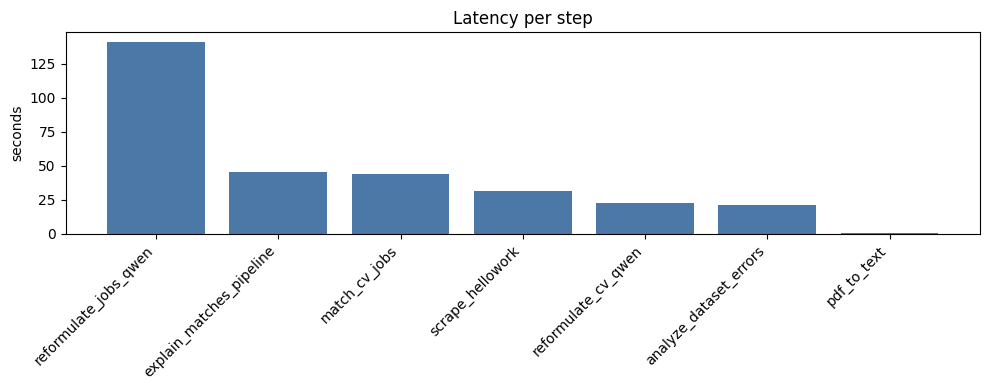

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    df_lat = pd.read_csv(LATENCY_CSV)
except FileNotFoundError:
    print(f'Missing {LATENCY_CSV}. Run the timed cells first.')
else:
    run_id = None
    if 'LATENCY_RUN_ID' in globals():
        run_id = LATENCY_RUN_ID

    if run_id and (df_lat['run_id'].astype(str) == str(run_id)).any():
        df_run = df_lat[df_lat['run_id'].astype(str) == str(run_id)]
    else:
        last_run = df_lat['run_id'].iloc[-1]
        df_run = df_lat[df_lat['run_id'] == last_run]
        run_id = last_run

    df_summary = df_run.groupby('step', as_index=False)['seconds'].sum()
    df_summary = df_summary.sort_values('seconds', ascending=False)

    print(f'Latency run_id={run_id}')
    print(df_summary.to_string(index=False))

    plt.figure(figsize=(10, 4))
    plt.bar(df_summary['step'], df_summary['seconds'], color='#4c78a8')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('seconds')
    plt.title('Latency per step')
    plt.tight_layout()
    plt.show()
